


<center>&copy; Research Group CAMMA, University of Strasbourg, <a href="http://camma.u-strasbg.fr">http://camma.u-strasbg.fr</a>



<a href="https://colab.research.google.com/github/CAMMA-public/ai4surgery/blob/master/ai4surgery_pt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



<div>
<img src="https://raw.githubusercontent.com/CAMMA-public/ai4surgery/master/figs/data_camma_logo_tr.png" width="100" align="left"/>
</div>

<h1><center>AI for surgery: Hands-on material using PyTorch</center></h1>



# Introduction

This hands-on lab demonstrates how designing and training a neural network works in practice.
Specifically, in this notebook we will develop and train a simple neural network for surgical tool detection in laparoscopic images. With the advent of advanced deep learning software libraries like pytorch, many of the steps involved in working with neural networks have been abstracted out allowing for a much simpler process.

To use the notebook, you will need to first log in to your google account.

# Basics

Please make sure you use GPU for the rest of the notebook: Goto **Runtime -> Change runtime type -> select GPU**

Below is a code cell that assigns the value 3 and 4 to variables *a* and *b*, respectively. Then the function *max* assigns the maximum value of *a* and *b* to a variable *c*. The values stored in all three variables are then printed to the screen.

In [ ]:
# This is a cell to code
# Comments following a # can be added and won't affect the code flow

# Assign the value 3 to the variable a and the value 4 to the variable 4
a = 3
b = 4

# Assign the maximum value of a and b to c
c = max(a, b)

# Return the values of a, b and c
print("input = {},{}  max = {}".format(a,b,c))

input = 3,4  max = 4


To run the code in the above cell, select it with a click and then either press the *play* button on the left of the cell, or use the shortcut "Command/Ctrl+Enter". To edit the code, just type directly into the cell and re-run the cell to see the result.


# Imports

We import some libraries which contain functions that are useful for building and visualizing neural networks. For those unfamiliar with programming, just execute the cell below and move on to the next section.

In [ ]:
# Import the required libraries
import os
# torch and torcvision libraries contain functions needed to build and train neural networks
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim

# Matlpotlib is a plotting library to help visualize our inputs and outputs data
import matplotlib.pyplot as plt
# Numpy is a library to simplify operations on matrices and other
# mathematical objects
import numpy as np
# Random is a library to help generate random numbers, make random choices, etc
import random
# PIL is a image processing library that we will use to handle images
import PIL
from PIL import Image
# We will use tqdm for pretty progress bar
from tqdm.notebook import tqdm
# deepcopy to copy the python data-structures
from copy import deepcopy

print("Libraries successfully imported!")
print("torch version", torch.__version__)

Libraries successfully imported!
torch version 1.12.0+cu113


# Dataset

The neural network will take an input image containg a surgical tool tip and classify the image as showing either a **grasper**, a **hook**, a **clipper** or a **scissor**. For this purpose, we will use [Cholec-tinytools](https://s3.unistra.fr/camma_public/github/ai4surgery/cholec-tinytools.zip), a dataset of images of surgical tool tips generated from **Cholec80**.


![](https://raw.githubusercontent.com/CAMMA-public/ai4surgery/master/figs/dataset.png)

In [ ]:
# Download and extract the tool tip dataset from an online repository
!wget 'https://s3.unistra.fr/camma_public/github/ai4surgery/cholec-tinytools.zip'
!unzip -q cholec-tinytools.zip && rm cholec-tinytools.zip
PATH = 'cholec-tinytools'
print("Dataset successfully extracted!")

--2022-07-18 13:41:09--  https://s3.unistra.fr/camma_public/github/ai4surgery/cholec-tinytools.zip
Resolving s3.unistra.fr (s3.unistra.fr)... 130.79.200.152
Connecting to s3.unistra.fr (s3.unistra.fr)|130.79.200.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41633689 (40M) [application/zip]
Saving to: ‘cholec-tinytools.zip’

cholec-tinytools.zi 100%[===================>]  39.70M  17.7MB/s    in 2.2s    

2022-07-18 13:41:12 (17.7 MB/s) - ‘cholec-tinytools.zip’ saved [41633689/41633689]

Dataset successfully extracted!


Note: The code above may take a few minutes to be executed.

In [ ]:
# Define the dataset characteristics and other hypter-parameters
# Each input image will have a resolution of 86x128 pixels
IMAGE_SIZE = (86, 128)
# RGB IMAGES are represented with 3 channels (red, blue, green)
CHANNELS = 3
# Number of images per batch
BATCH_SIZE = 4
# device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# number of epochs for the training
NUM_EPOCHS = 15
# training or inference
DO_TRAINING = True
# learnig rate and momentum for optimization
LEARNING_RATE = 0.001
MOMENTUM = 0.9
print("Dataset characteristics defined!")

Dataset characteristics defined!


Each pixel of an RGB image can be represented as a combination of red, green and blue values each between 0-255.
![](https://raw.githubusercontent.com/CAMMA-public/ai4surgery/master/figs/rgb_decomp.png)


In [ ]:
# Preprocess the images in the dataset

# The training images are scaled down (i.e. normalized using the statistics from the imagenet dataset)

# To artificially augment the training set, we additionally use variants of
# each image generated by randomnly rotating it by 0-20 degrees
imnet_stats = {"mean": [0.485, 0.456, 0.406], "std": [0.229, 0.224, 0.225]}
transform_dict = {
    "train": transforms.Compose(
        [
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(30),
            transforms.ToTensor(),
            transforms.Normalize(mean=imnet_stats["mean"], std=imnet_stats["std"]),
        ]
    ),
    "test": transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(mean=imnet_stats["mean"], std=imnet_stats["std"]),
        ]
    ),
}
transform_dict["val"] = deepcopy(transform_dict["test"])

# make a train data-loader
train_data = torchvision.datasets.ImageFolder(
    root=os.path.join(PATH, "train"), transform=transform_dict["train"]
)
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=1
)
# make a val data-loader
val_data = torchvision.datasets.ImageFolder(
    root=os.path.join(PATH, "validation"), transform=transform_dict["val"]
)
val_loader = torch.utils.data.DataLoader(
    val_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=1
)
# make a test data-loader
test_data = torchvision.datasets.ImageFolder(
    root=os.path.join(PATH, "test"), transform=transform_dict["test"]
)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=1
)
# The names of surgical tools we want to classify
CLASS_NAMES = train_loader.dataset.classes
# The numbers of surgical tools (i.e. classes) we want to classify
NUMBER_CLASSES = len(CLASS_NAMES)

# Index to class_names
INDEX_To_CLASS = {v: k for k, v in train_loader.dataset.class_to_idx.items()}
print(
    "\n Dataset successfully preprocessed! \nIt has {} classes with names {}".format(
        NUMBER_CLASSES, INDEX_To_CLASS
    )
)


 Dataset successfully preprocessed! 
It has 4 classes with names {0: 'clipper', 1: 'grasper', 2: 'hook', 3: 'scissor'}


### Preview 4 random images from the training set

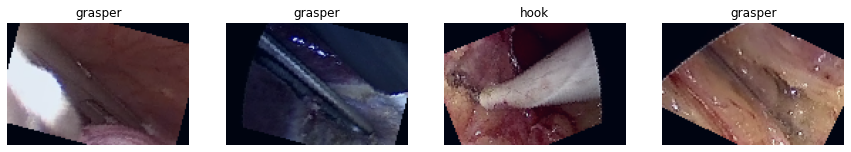

In [ ]:
# Define the figure using a matplotlib.pyplot function
fig, axes = plt.subplots(1, 4, figsize=(15, 15))
# random_batch =  random.randint(0, len(train_set)-1)
random_images, random_labels = next(iter(train_loader))
# For loops are used to iterate over a sequence, in this case each
# image being plotted
for image_number, axs in enumerate(axes):
    img = random_images[image_number].cpu().numpy().transpose(1, 2, 0)
    vmin, vmax = img.min(), img.max()
    img = (img - vmin) / (vmax - vmin)
    axs.imshow(img)
    axs.axis("off")
    axs.set_title(INDEX_To_CLASS[random_labels[image_number].item()])

Rerun the cell above to visualize the different appearances of the 4 types of tool tips in the dataset.

# Convolutions



<div>
<center>
<img src="https://raw.githubusercontent.com/CAMMA-public/ai4surgery/master/figs/convolution.gif" width="350" /> </center>
</div>

Here we will apply filters for edge detection to demonstrate the kind of information a single convolutional filter can extract from an image.

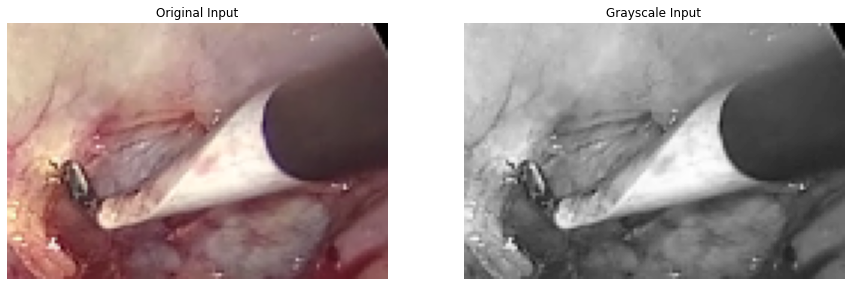

In [ ]:
# Read a sample image
img = Image.open(os.path.join(PATH, "train/hook/7013_16226.png"))
img_gray = torchvision.transforms.Grayscale()(img)
# Visualize result
fig = plt.figure(figsize=(15, 5))
# Display the original input and it's grayscale version
fig.add_subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Input")
plt.axis("off")

fig.add_subplot(1, 2, 2)
plt.imshow(img_gray, "gray")
plt.title("Grayscale Input")
plt.axis("off")
plt.show()

Kernels for edge detection

<div>
<center>
<img src="https://raw.githubusercontent.com/CAMMA-public/ai4surgery/master/figs/sobel_filter.png" width="600" /> </center>
</div>


The above kernels or filters contain [known weight values](https://en.wikipedia.org/wiki/Sobel_operator) for horizontal and vertical edges detection.


In [ ]:
# Define filters for edge detection

# Horizontal filter
horizontal_edge_detector = torch.tensor(
    [[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=torch.float32
)

# Vertical filter
vertical_edge_detector = torch.tensor(
    [[1, 0, -1], [2, 0, -2], [1, 0, -1]], dtype=torch.float32
)

# Display filters
# We use ".numpy()" to display the result as a matrix
print("Horizontal filter")
print(horizontal_edge_detector.numpy(), horizontal_edge_detector.numpy().shape)

print("Vertical filter")
print(vertical_edge_detector.numpy(), vertical_edge_detector.numpy().shape)

print("Edge detectors tensors successfully defined")


Horizontal filter
[[ 1.  2.  1.]
 [ 0.  0.  0.]
 [-1. -2. -1.]] (3, 3)
Vertical filter
[[ 1.  0. -1.]
 [ 2.  0. -2.]
 [ 1.  0. -1.]] (3, 3)
Edge detectors tensors successfully defined


Since most pytorch functions are designed to take multiple batches of input images at a time, we first convert the input image to a 4 dimensional matrix as shown below.

In [ ]:
# Expand to have 4 dimensional (4D) matrix
# This is done because the pytorch expects the input to the
# convolution to be in the shape Batch x Channels x Height x Width
# In this case Batch = 1

img_4d = transforms.ToTensor()(img_gray)[None]
print(img_4d.shape)

torch.Size([1, 1, 86, 128])


### Convolution using torch functional API `torch.nn.functional` with fixed weights
Apply a convolution for horizontal edge detection on the grayscale image

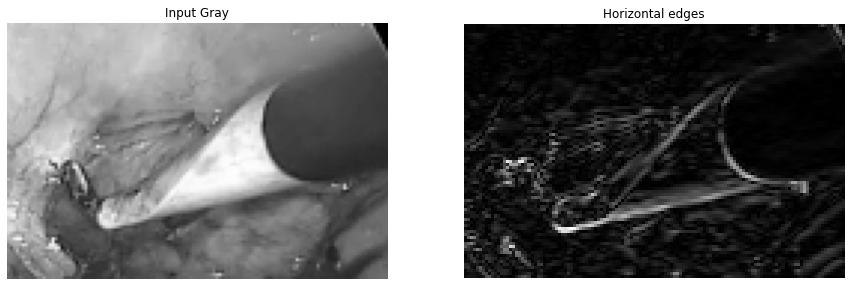

In [ ]:
# Convolution on the image with horizontal filter
# The filter is shifted of 1 pixel (strides = 1) at every step,
# zero padding is applied such the output will have the "SAME" spatial
# dimensions as the input

h_weights = horizontal_edge_detector[None, None]

conv_h = F.conv2d(img_4d, h_weights, stride=1, padding=0)

# The filter will output high absolute values (maybe positive or negative)
# when it detects horizontal edges
horizontal_edge_img = torch.abs(conv_h)

# Visualize result
fig = plt.figure(figsize=(15, 5))

# Display input
fig.add_subplot(1, 2, 1)
plt.imshow(img_4d.numpy()[0, 0], "gray")
plt.title("Input Gray")
plt.axis("off")

# Display detected horizontal edges
fig.add_subplot(1, 2, 2)
plt.imshow(horizontal_edge_img.numpy()[0, 0], "gray")
plt.title("Horizontal edges")
plt.axis("off")

plt.show()

Similarly for vertical edge detection

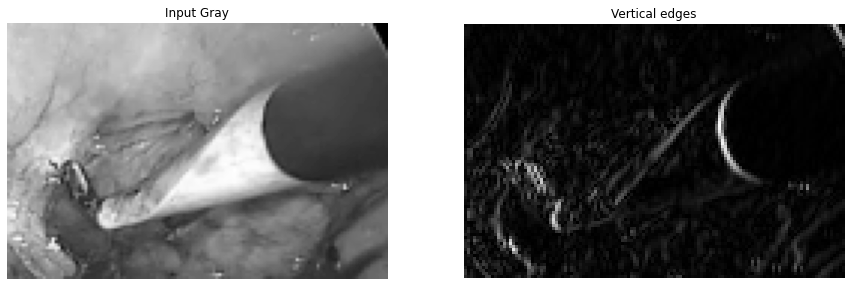

In [ ]:
# Convolution on the image with vertical filter

v_weights = vertical_edge_detector[None, None]

conv_h = F.conv2d(img_4d, v_weights, stride=1, padding=0)

# The filter will output high absolute values (maybe positive or negative)
# when it detects horizontal edges
vertical_edge_img = torch.abs(conv_h)

# Visualize result
fig = plt.figure(figsize=(15, 5))

# Display input
fig.add_subplot(1, 2, 1)
plt.imshow(img_4d.numpy()[0, 0], "gray")
plt.title("Input Gray")
plt.axis("off")

# Display detected horizontal edges
fig.add_subplot(1, 2, 2)
plt.imshow(vertical_edge_img.numpy()[0, 0], "gray")
plt.title("Vertical edges")
plt.axis("off")

plt.show()

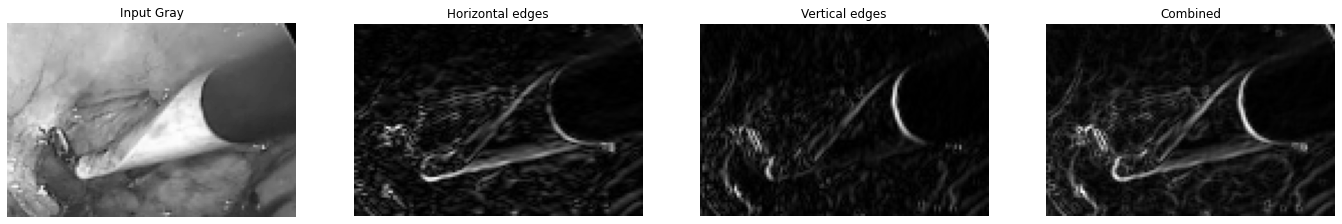

In [ ]:
# The detected edges in the horizontal and vertical direction can then be
# combined to identify all the edges in the image

# Create a single output by adding the detected vertical and horizontal edges
edge_detections = horizontal_edge_img + vertical_edge_img

# Visualize result
fig = plt.figure(figsize=(30,5))

# Display input
fig.add_subplot(1, 5, 1); plt.imshow(img_4d.numpy()[0,0], 'gray');
plt.title("Input Gray"); plt.axis("off")

# Display detected horizontal edges
fig.add_subplot(1, 5, 2); plt.imshow(horizontal_edge_img.numpy()[0,0], 'gray');
plt.title("Horizontal edges"); plt.axis("off")

# Display detected horizontal edges
fig.add_subplot(1, 5, 3); plt.imshow(vertical_edge_img.numpy()[0,0], 'gray');
plt.title("Vertical edges"); plt.axis("off")

# Display combined horizontal and vertical edges
fig.add_subplot(1, 5, 4); plt.imshow(edge_detections.numpy()[0,0], 'gray');
plt.title("Combined"); plt.axis("off")

plt.show()

When building neural networks, filter weights will be learned during training to extract and aggregate information relevant to the target task.

## Convolution using `torch.nn` with random learnable weights

`torch.nn` is a high-level interface library designed to be more intuitive and user-friendly to enable fast experimentation with deep neural networks.

In [ ]:
# Again, we expand the dimensions so that our input is in the shape
# Batch x Channels X Height x Width

img_4d = transforms.ToTensor()(img)[None]
print(img_4d.shape)

torch.Size([1, 3, 86, 128])


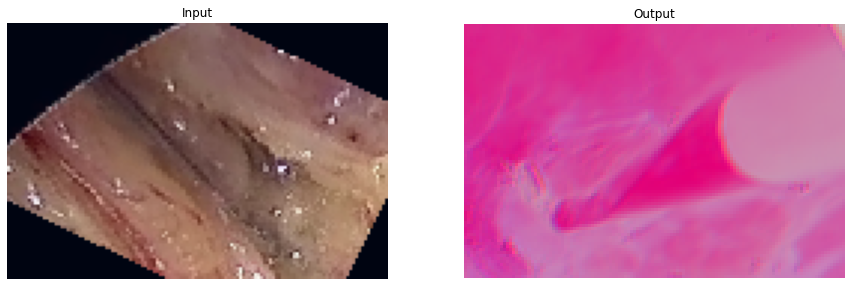

In [ ]:
# Convolution operation (i.e. untrained kernel weights)
conv_img = torch.nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1)(
    img_4d
)
# take the ithe image, and convert from CxHxW to HxWxC
conv_img = conv_img.detach().numpy()[0].transpose(1, 2, 0)
# Normalize so that our output values lie within a valid range for display
# i.e. 0-1
min, max = conv_img.min(), conv_img.max()
conv_img = (conv_img - min) / (max - min)

# Visualize result
fig = plt.figure(figsize=(15, 5))

# Display input
fig.add_subplot(1, 2, 1)
plt.imshow(img)
plt.title("Input")
plt.axis("off")

# Display convolution output
fig.add_subplot(1, 2, 2)
plt.imshow(conv_img)
plt.title("Output")
plt.axis("off")
plt.show()

Here the kernel weights are randomly initiated and not trained to extract any particular feature, hence the output changes at every execution. This demonstrates the kind of information that can get filtered out or focused on by a single convolution.

**Note: re-run the above cell to see the output from different random weights for the convolution**

## Pooling


<div>
<center>
<img src="https://raw.githubusercontent.com/CAMMA-public/ai4surgery/master/figs/pooling.png" width="600" /> </center>
</div>


Pooling layers apply mathematical operations such as averaging and maximum to reduce the size of the inputs. Such operations are applied using sliding filters, similar to the convolutional filters described above.

We will now apply max pooling and average pooling to visualize how they differently affect an input. Feel free to explore other filter sizes.

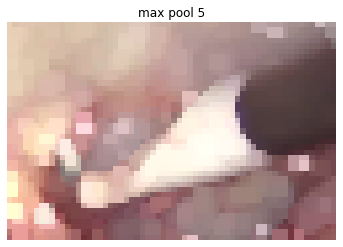

In [ ]:
# Experimenting with max pooling kernel sizes

# Change the value below to see how kernel size affects the output
kernel_size = 5

# Max Pooling using kernel_size x kernel_size (default: 5x5)
# The filter is shifted with a stride of 2 in both the horizontal
# and vertical directions.
maxpooled_img = F.max_pool2d(img_4d, kernel_size=kernel_size, stride=2)

# Visualize the max pooling output
fig = plt.figure()
plt.imshow(maxpooled_img.numpy()[0].transpose(1, 2, 0))
plt.title("max pool {}".format(kernel_size))
plt.axis("off")
plt.show()

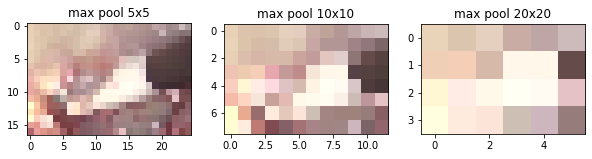

In [ ]:
# Experimenting with max pooling kernel sizes

# Max Pooling using 5x5 kernel, strides of 5
maxpooled_img5x5 = F.max_pool2d(img_4d, kernel_size=(5, 5), stride=5)

# Max Pooling using 10x10 kernel, strides of 10
maxpooled_img10x10 = F.max_pool2d(img_4d, kernel_size=(10, 10), stride=10)

# Max Pooling using 20x20 kernel, strides of 20
maxpooled_img20x20 = F.max_pool2d(img_4d, kernel_size=(20, 20), stride=20)

# Visualize max pooling output
fig = plt.figure(figsize=(10, 5))

fig.add_subplot(1, 3, 1)
plt.imshow(maxpooled_img5x5.numpy()[0].transpose(1, 2, 0))
plt.title("max pool 5x5")

fig.add_subplot(1, 3, 2)
plt.imshow(maxpooled_img10x10.numpy()[0].transpose(1, 2, 0))
plt.title("max pool 10x10")

fig.add_subplot(1, 3, 3)
plt.imshow(maxpooled_img20x20.numpy()[0].transpose(1, 2, 0))
plt.title("max pool 20x20")

plt.show()

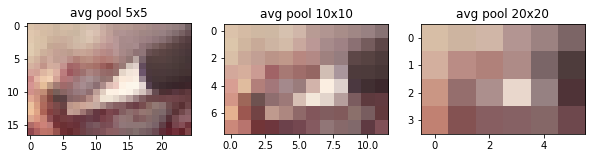

In [ ]:
# Experimenting with average pooling kernel sizes

# Average Pooling using 5x5 kernel, stride of 5
avgpooled_img5x5 = F.avg_pool2d(img_4d, kernel_size=(5, 5), stride=5)

# Average Pooling using 10x10 kernel, stride of 10
avgpooled_img10x10 = F.avg_pool2d(img_4d, kernel_size=(10, 10), stride=10)

# Average Pooling using 20x20 kernel, strides of 20
avgpooled_img20x20 = F.avg_pool2d(img_4d, kernel_size=(20, 20), stride=20)

# Visualize average pooling output
fig = plt.figure(figsize=(10, 5))

fig.add_subplot(1, 3, 1)
plt.imshow(avgpooled_img5x5.numpy()[0].transpose(1, 2, 0))
plt.title("avg pool 5x5")

fig.add_subplot(1, 3, 2)
plt.imshow(avgpooled_img10x10.numpy()[0].transpose(1, 2, 0))
plt.title("avg pool 10x10")

fig.add_subplot(1, 3, 3)
plt.imshow(avgpooled_img20x20.numpy()[0].transpose(1, 2, 0))
plt.title("avg pool 20x20")

plt.show()



In both average and max pooling, there is a trade-off between image(or feature) size and spatial detail.

# Tool Classification

It is now time to build a neural network for surgical tool classification. The classification model is defined below as a sequential stack of layers (picturized below).


<div>
<center>
<img src="https://raw.githubusercontent.com/CAMMA-public/ai4surgery/master/figs/cnn.png" width="750" /> </center>
</div>

In [ ]:
class ToolNet(torch.nn.Module):
    def __init__(self):
        super(ToolNet, self).__init__()
        # Adding a convolution with 16 5x5 filters
        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=5)
        # Adding max pooling over 5x5 patches of the previous layers output
        self.max_pool1 = torch.nn.MaxPool2d(5)
        # Adding a second convolution with 32 3x3 filters
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3)
        # Adding a fully connected layer with 4096 outputs
        self.fc1 = torch.nn.Linear(9856, 4096)
        # Adding a fully connected layer with 4096 outputs
        self.fc2 = torch.nn.Linear(4096, 2048)
        # Adding a fully connected layer with 4096 outputs
        self.fc3 = torch.nn.Linear(2048, 4)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.max_pool1(x)
        x = F.relu(self.conv2(x))
        x = x.view(-1, 9856)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

tool_net_model = ToolNet().to(DEVICE)
print("Neural network architecture successfully defined!\n", tool_net_model)

Neural network architecture successfully defined!
 ToolNet(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (max_pool1): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=9856, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=2048, bias=True)
  (fc3): Linear(in_features=2048, out_features=4, bias=True)
)


Notes:
*   The output of the convolutional layer is a 3 dimensional CxHxW matrix for each element of the batch. This should be flattened to a single row of C*H*W elements before applying a fully connected layers.
*   Fully connected layers are sometimes called dense layers because each output (here referred to as units) is densely connected to the previous layer.
*   The model ends with a fully connected layer with 4 outputs corresponding to number of classes.


In [ ]:
# Defining the optimization method and a loss function

# The optimization method is stochasitc gradient descent(SGD)
optimizer = optim.SGD(tool_net_model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

# Categorical cross entropy is commonly used loss for classification problems
criterion = torch.nn.CrossEntropyLoss()

Let's run the untrained network on a single image to see what the network input and output look like.

Input:


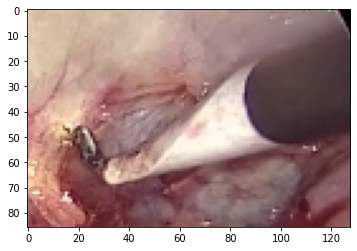

Output:
[-0.00245007  0.02061233  0.03122433  0.01975199]
['clipper', 'grasper', 'hook', 'scissor']


In [ ]:
# Read image
img =Image.open(os.path.join(PATH, "train/hook/7013_16226.png"))
print('Input:')
plt.imshow(img)
plt.show()

# Expand to have 4 dimensional (4D) image tensor
input_4d = transforms.ToTensor()(img)[None].to(DEVICE)

# Uses the untrained model defined above to predict
prediction = tool_net_model(input_4d).detach().cpu().numpy()
print('Output:')
print(prediction[0])
print(CLASS_NAMES)

The network predicts 4 probability values corresponding to every considered class. Right now, the predictions are random; we will train the network to learn parameters to make better predictions.

In [ ]:
# helper function to compute the accuracy from the ground truth labels and model predictions
def accuracy(labels, predictions):
    _, predicted = torch.max(predictions, 1)
    acc = (predicted == labels).float()
    return acc.mean().item()


# helper function to train the model for one epoch of training set
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    # iterate through images and their labels
    train_loss, acc_metric_train = 0.0, 0.0
    # pbar = tqdm(range(len(loader)))
    for images, labels in tqdm(loader, desc="training epoch"):
        # transfer the images and labels to GPU
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        # forward + backward + optimize
        # forward
        logits = model(images)
        loss = criterion(logits, labels)
        # zero the parameter gradients
        optimizer.zero_grad()
        # backward
        loss.backward()
        # optimize
        optimizer.step()
        # compute stats
        train_loss += loss.item()
        acc_metric_train += accuracy(labels, logits)
    train_loss /= len(loader)
    acc_metric_train = 100 * acc_metric_train / len(loader)
    return model, train_loss, acc_metric_train

# helper function to evaluate the model
def val_epoch(model, loader, criterion, desc="val"):
    val_loss, acc_metric_val = 0.0, 0.0
    # pbar = tqdm(range(len(loader)))
    with torch.no_grad():
        model.eval()
        for images, labels in tqdm(loader, desc=desc+" epoch"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            # just forward
            logits = model(images)
            loss = criterion(logits, labels)
            val_loss += loss.item()
            acc_metric_val += accuracy(labels, logits)
        val_loss /= len(val_loader)
        acc_metric_val = 100 * acc_metric_val / len(loader)
    return model, val_loss, acc_metric_val

In [ ]:
# accuracy on the test set before training
_, test_loss, acc_metric_test = val_epoch(tool_net_model, test_loader, criterion, desc="test")
print("test loss: {:.2f} test accuracy: {:.1f}".format(test_loss, acc_metric_test))

test epoch:   0%|          | 0/150 [00:00<?, ?it/s]

test loss: 4.14 test accuracy: 43.1


In [ ]:
# Training our neural network
# The model will iterate over the training data 20 times (i.e. epochs)
if DO_TRAINING:
    train_logs = []
    # pbar = tqdm(range(NUM_EPOCHS))
    for epoch in range(NUM_EPOCHS):
        print("\n***************************************************")
        print("Epoch {}/{}".format(epoch+1, NUM_EPOCHS))
        # train the model for one epoch
        tool_net_model, train_loss, acc_metric_train = train_epoch(
            tool_net_model, train_loader, criterion, optimizer
        )
        # evaluate the model on the validation set
        tool_net_model, val_loss, acc_metric_val = val_epoch(
            tool_net_model, val_loader, criterion
        )
        # log the stats
        train_logs.append(
            {
                "train_loss": train_loss,
                "val_loss": val_loss,
                "acc_metric_train": acc_metric_train,
                "acc_metric_val": acc_metric_val,
            }
        )
        print(
            "train_loss: {:.2f} train accuracy: {:.1f} val_loss: {:.2f} val accuracy: {:.1f}".format(
                train_loss, acc_metric_train, val_loss, acc_metric_val
            )
        )


***************************************************
Epoch 1/15


training epoch:   0%|          | 0/300 [00:00<?, ?it/s]

val epoch:   0%|          | 0/50 [00:00<?, ?it/s]

train_loss: 1.03 train accuracy: 57.2 val_loss: 0.85 val accuracy: 64.5

***************************************************
Epoch 2/15


training epoch:   0%|          | 0/300 [00:00<?, ?it/s]

val epoch:   0%|          | 0/50 [00:00<?, ?it/s]

train_loss: 0.85 train accuracy: 67.2 val_loss: 0.69 val accuracy: 74.5

***************************************************
Epoch 3/15


training epoch:   0%|          | 0/300 [00:00<?, ?it/s]

val epoch:   0%|          | 0/50 [00:00<?, ?it/s]

train_loss: 0.75 train accuracy: 71.8 val_loss: 0.64 val accuracy: 76.0

***************************************************
Epoch 4/15


training epoch:   0%|          | 0/300 [00:00<?, ?it/s]

val epoch:   0%|          | 0/50 [00:00<?, ?it/s]

train_loss: 0.68 train accuracy: 76.2 val_loss: 0.58 val accuracy: 79.0

***************************************************
Epoch 5/15


training epoch:   0%|          | 0/300 [00:00<?, ?it/s]

val epoch:   0%|          | 0/50 [00:00<?, ?it/s]

train_loss: 0.64 train accuracy: 76.8 val_loss: 0.55 val accuracy: 81.5

***************************************************
Epoch 6/15


training epoch:   0%|          | 0/300 [00:00<?, ?it/s]

val epoch:   0%|          | 0/50 [00:00<?, ?it/s]

train_loss: 0.60 train accuracy: 78.8 val_loss: 0.56 val accuracy: 83.0

***************************************************
Epoch 7/15


training epoch:   0%|          | 0/300 [00:00<?, ?it/s]

val epoch:   0%|          | 0/50 [00:00<?, ?it/s]

train_loss: 0.55 train accuracy: 80.2 val_loss: 0.57 val accuracy: 82.5

***************************************************
Epoch 8/15


training epoch:   0%|          | 0/300 [00:00<?, ?it/s]

val epoch:   0%|          | 0/50 [00:00<?, ?it/s]

train_loss: 0.51 train accuracy: 81.7 val_loss: 0.49 val accuracy: 84.5

***************************************************
Epoch 9/15


training epoch:   0%|          | 0/300 [00:00<?, ?it/s]

val epoch:   0%|          | 0/50 [00:00<?, ?it/s]

train_loss: 0.46 train accuracy: 83.3 val_loss: 0.43 val accuracy: 85.5

***************************************************
Epoch 10/15


training epoch:   0%|          | 0/300 [00:00<?, ?it/s]

val epoch:   0%|          | 0/50 [00:00<?, ?it/s]

train_loss: 0.47 train accuracy: 83.3 val_loss: 0.46 val accuracy: 85.0

***************************************************
Epoch 11/15


training epoch:   0%|          | 0/300 [00:00<?, ?it/s]

val epoch:   0%|          | 0/50 [00:00<?, ?it/s]

train_loss: 0.42 train accuracy: 85.6 val_loss: 0.45 val accuracy: 84.0

***************************************************
Epoch 12/15


training epoch:   0%|          | 0/300 [00:00<?, ?it/s]

val epoch:   0%|          | 0/50 [00:00<?, ?it/s]

train_loss: 0.37 train accuracy: 86.8 val_loss: 0.40 val accuracy: 86.5

***************************************************
Epoch 13/15


training epoch:   0%|          | 0/300 [00:00<?, ?it/s]

val epoch:   0%|          | 0/50 [00:00<?, ?it/s]

train_loss: 0.35 train accuracy: 87.2 val_loss: 0.40 val accuracy: 86.0

***************************************************
Epoch 14/15


training epoch:   0%|          | 0/300 [00:00<?, ?it/s]

val epoch:   0%|          | 0/50 [00:00<?, ?it/s]

train_loss: 0.34 train accuracy: 88.2 val_loss: 0.50 val accuracy: 83.5

***************************************************
Epoch 15/15


training epoch:   0%|          | 0/300 [00:00<?, ?it/s]

val epoch:   0%|          | 0/50 [00:00<?, ?it/s]

train_loss: 0.31 train accuracy: 90.6 val_loss: 0.41 val accuracy: 85.5


### Plot training stats

15


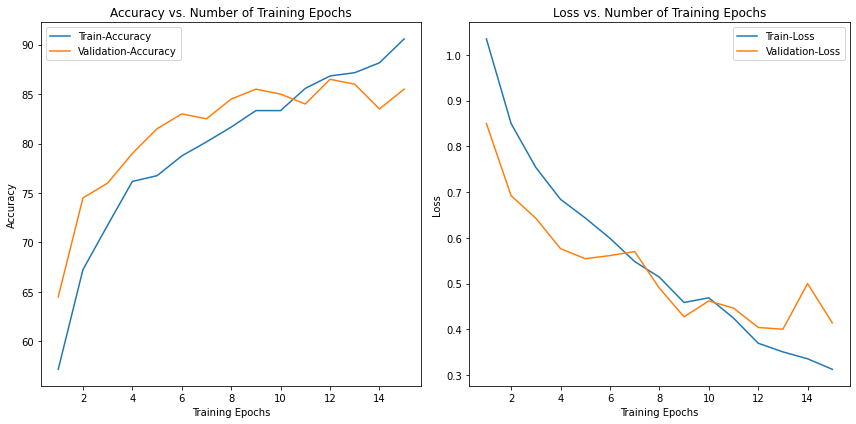

In [ ]:
loss_train = [h['train_loss'] for h in train_logs]
loss_val = [h['val_loss'] for h in train_logs]
accuracy_train = [h['acc_metric_train'] for h in train_logs]
accuracy_val = [h['acc_metric_val'] for h in train_logs]
num_epochs = len(loss_train)
print(len(train_logs))
plt.figure(figsize=(12, 6))
titles = ["Accuracy vs. Number of Training Epochs", "Loss vs. Number of Training Epochs"]
ylabels = ["Accuracy", "Loss"]
yplots = [(accuracy_train, accuracy_val), (loss_train, loss_val)]
for i, title, ylabel, yplot in zip(range(2), titles, ylabels, yplots):
    plt.subplot(1, 2, i + 1)
    plt.title(title)
    plt.xlabel("Training Epochs")
    plt.ylabel(ylabel)
    plt.plot(range(1,num_epochs+1),yplot[0],label="Train-"+ylabel)
    plt.plot(range(1,num_epochs+1),yplot[1],label="Validation-"+ylabel)
    #plt.ylim((0.3,1.))
    #plt.xticks(np.arange(1, num_epochs+1, 1.0))
    plt.legend()
plt.gcf().tight_layout()

The above graphic plots the neural network accuracy on the training set and on the validation set over training epochs. When the two lines converge training is effective, when those diverge (i.e. higher accuracy on the training set then on the validation set) the model is overfitting to the training data. An overfitted model will fail to generalize to unseen data (i.e. will perform poorly on test data).

In [ ]:
# accuracy on the test set after the training
_, test_loss, acc_metric_test = val_epoch(tool_net_model, test_loader, criterion, desc="test")
print("test loss: {:.2f} test accuracy: {:.1f}".format(test_loss, acc_metric_test))

test epoch:   0%|          | 0/150 [00:00<?, ?it/s]

test loss: 1.49 test accuracy: 85.3


The evaluation function on the test set returns the model loss and accuracy. The goal is to get the loss close to 0 and accuracy close to 1 (100%).

Finally, we visualize the results on a few random images from the test set.

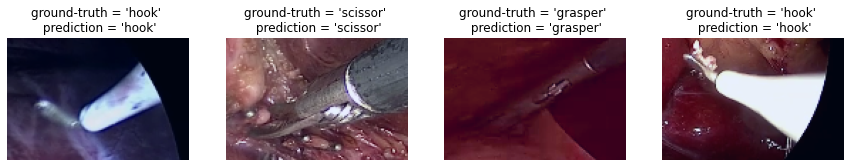

In [ ]:
test_loader_shuffled = torch.utils.data.DataLoader(
    test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=1
)
fig, axes = plt.subplots(1, 4, figsize=(15, 15))
random_images, random_labels = next(iter(test_loader_shuffled))
tool_net_model.eval()
model_output = tool_net_model(random_images.to(DEVICE))
_, prediction = torch.max(model_output, 1)
prediction = prediction.cpu().numpy()

for image_number, axs in enumerate(axes):
    img = random_images[image_number].cpu().numpy().transpose(1, 2, 0)
    vmin, vmax = img.min(), img.max()
    img = (img - vmin) / (vmax - vmin)
    axs.imshow(img)
    axs.axis("off")
    gt_label = INDEX_To_CLASS[random_labels[image_number].item()]
    pred_label = INDEX_To_CLASS[prediction[image_number]]
    axs.set_title("ground-truth = '{}' \n prediction = '{}'".format(gt_label, pred_label))

**Re-run the above cell to see the predictions on different test images**

# Design your surgical tool classifier

Here's a copy of the same model to play around with. Your aim shuld be to design a network architecture and pick its corresponding hyperparameters to maximize the validation accuracy.

*   See what effect increasing and decreasing the number of epochs has on training
*   Play around with the learning rate to see what's the optimal value
*   Try changing the parameters (number of filters, kernel size, etc...)
*   Try out different activation functions ("tanh", "relu", etc...)
*   Try adding or removing layers
